## Materials

- How can you register your own material refractive index info for a particular PDK?
- How can you use the same material index when using different plugins (tidy3d, meep, lumerical ...)?

You can define a material by name, real refractive index, complex refractive index (for loss) or by a function of wavelength.

In [1]:
import numpy as np

import gdsfactory as gf
import gdsfactory.simulation.gmeep as gm
import gdsfactory.simulation.gtidy3d as gt
from gdsfactory.components.taper import taper_sc_nc
from gdsfactory.pdk import Pdk

gf.config.rich_output()
PDK = gf.generic_tech.get_generic_pdk()
PDK.activate()

2023-02-20 17:55:05.701 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.43.1


Using MPI version 4.0, 1 processes


2023-02-20 17:55:07.450 | INFO     | gdsfactory.simulation.gmeep:<module>:34 - Meep '1.25.0-beta' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/meep']


[17:55:08] INFO     Using client version: 1.8.4                                                     ]8;id=971333;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py\__init__.py]8;;\:]8;id=184113;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py#120\120]8;;\

2023-02-20 17:55:08.263 | INFO     | gdsfactory.simulation.gtidy3d:<module>:54 - Tidy3d '1.8.4' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d']


2023-02-20 17:55:08.370 | INFO     | gdsfactory.technology.layer_views:__init__:785 - Importing LayerViews from YAML file: /home/runner/work/gdsfactory/gdsfactory/gdsfactory/generic_tech/layer_views.yaml.


2023-02-20 17:55:08.377 | INFO     | gdsfactory.pdk:activate:206 - 'generic' PDK is now active


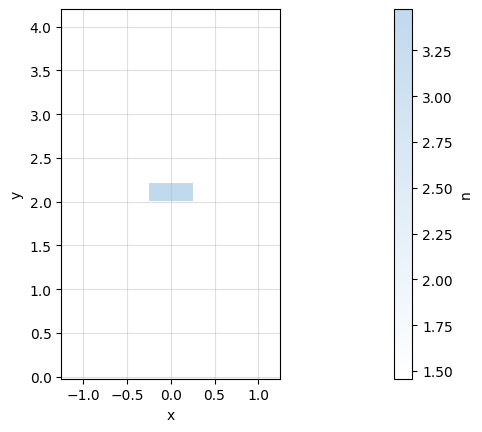

In [2]:
strip = gt.modes.Waveguide(
    wavelength=1.55,
    wg_width=0.5,
    wg_thickness=0.22,
    slab_thickness=0.0,
    ncore="si",
    nclad="sio2",
)
strip.plot_index()

## Option 1: define material with a value

In [3]:
PDK.materials_index.update(sin=2)

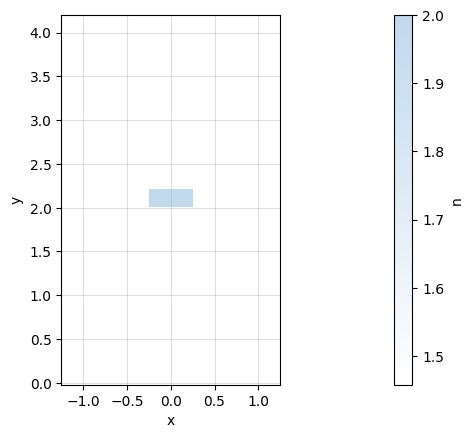

In [4]:
strip = gt.modes.Waveguide(
    wavelength=1.55,
    wg_width=0.5,
    wg_thickness=0.22,
    slab_thickness=0.0,
    ncore="sin",
    nclad="sio2",
)
strip.plot_index()

## Option 2: define material with a function

In [5]:
def sin(wav: float) -> float:
    w = [1.3, 1.5]
    n = [1.9, 2.1]
    p = np.polyfit(w, n, 1)
    return np.polyval(p, wav)


PDK.materials_index.update(sin=sin)

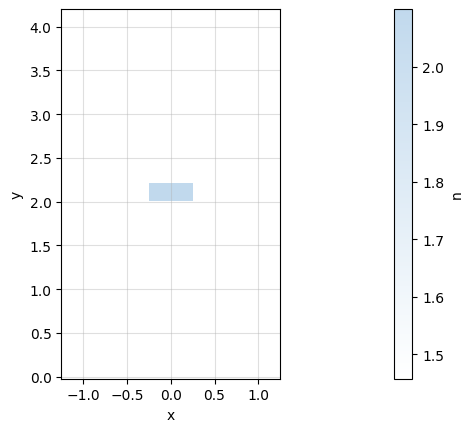

In [6]:
strip = gt.modes.Waveguide(
    wavelength=1.5,
    wg_width=0.5,
    wg_thickness=0.22,
    slab_thickness=0.0,
    ncore="sin",
    nclad="sio2",
)
strip.plot_index()

In [7]:
c = taper_sc_nc(length=10)
c

AppLayout(children=(Tab(children=(VBox(children=(HBox(children=(Button(layout=Layout(border_bottom='solid 2px …

taper_strip_to_ridge_7a2ed5b1: uid b4da8adc, ports ['o1', 'o2'], references [], 2 polygons


Effective index of computed modes:  [[2.4159362 1.780838 ]]


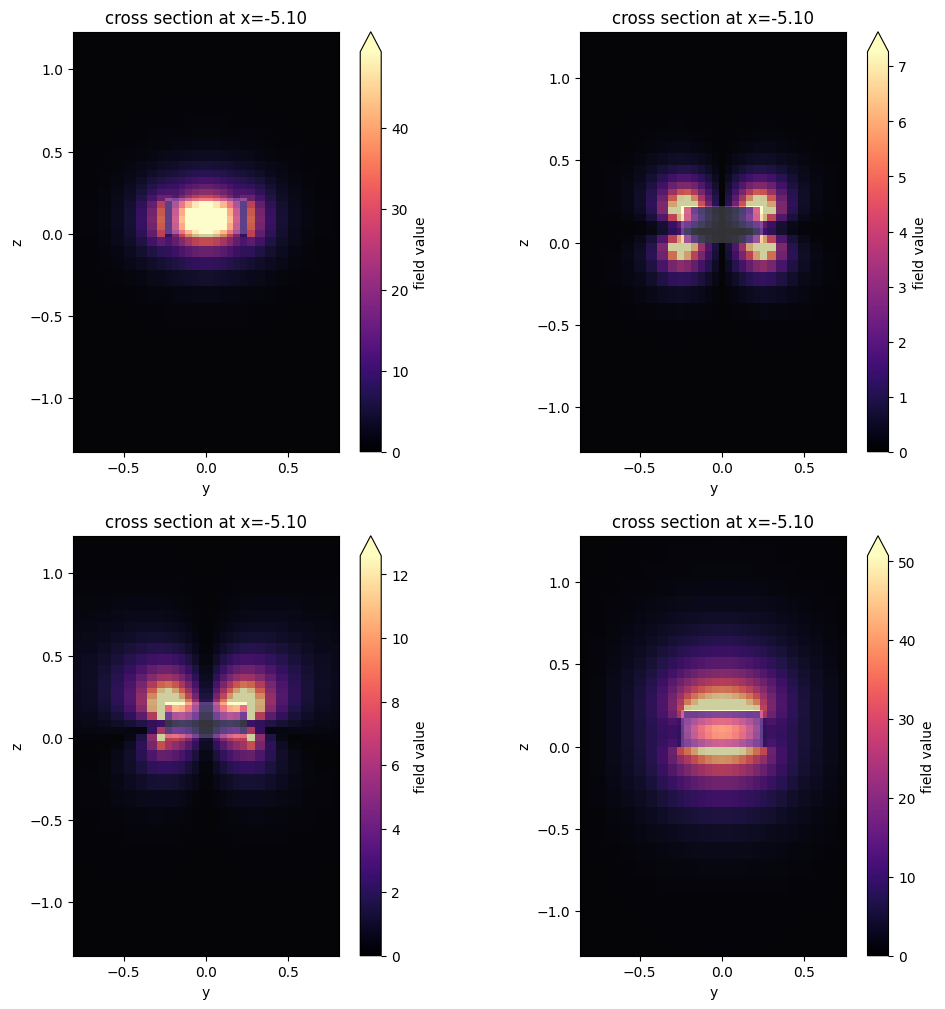

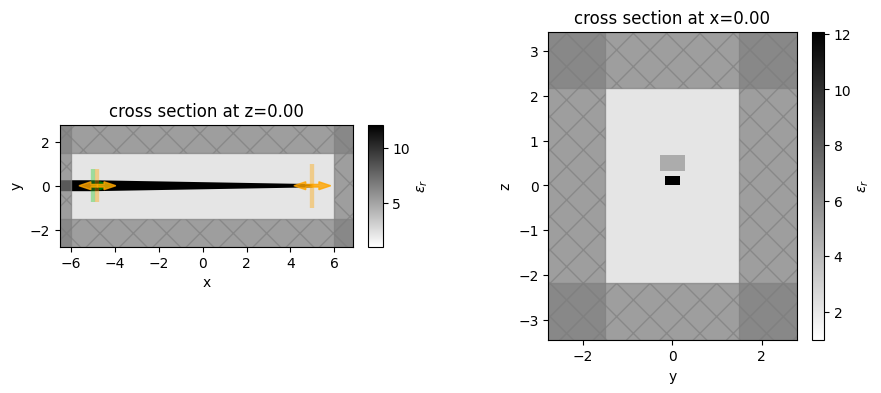

In [8]:
s = gt.get_simulation(c, plot_modes=True)
fig = gt.plot_simulation_xz(s)

<meep.simulation.Simulation object at 0x7f5683bf7130>

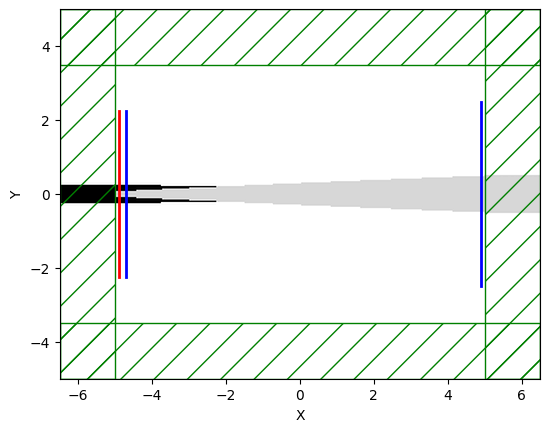

In [9]:
c = taper_sc_nc(length=10)
gm.write_sparameters_meep(
    c, ymargin=3, run=False, wavelength_start=1.31, wavelength_stop=1.36
)

## Register materials into a PDK

You can register all `materials_index` functions into a PDK.

In [10]:
def sin(wav: float) -> float:
    w = [1.3, 1.5]
    n = [1.9, 2.1]
    p = np.polyfit(w, n, 1)
    return np.polyval(p, wav)


def si(wav: float) -> float:
    w = [1.3, 1.5]
    n = [3.45, 3.47]
    p = np.polyfit(w, n, 1)
    return np.polyval(p, wav)


materials_index = dict(sin=sin, si=si)

p = Pdk(name="fab_a", materials_index=materials_index)